In [37]:
import logging
import os
import config
import numpy as np
from scipy.linalg import block_diag
from pymor.models.iosys import LTIModel
import matplotlib.pyplot as plt
import numpy.linalg as npl

#### 这里开始是根据模型建立一个线性时间不变系统
$$
\begin{bmatrix}
Ex'\\
y
\end{bmatrix}=
\begin{bmatrix}
A &B\\
C &D
\end{bmatrix}
\begin{bmatrix}
Qx\\
u
\end{bmatrix}

使得

\begin{bmatrix}
A &B\\
-C &-D
\end{bmatrix}
=
\mathcal{J}-\mathcal{R}
\\
$$
$$
并且有\mathcal{J}=-\mathcal{J}^T,\mathcal{R}是一个实对称正定矩阵$$


如果这个是一个pH系统，它可以写成
$$
Ex' = (J-R)Qx + (G-P)u\\
y = (G+P)^TQx + (S-N)u
$$
其中$$J=-J^T,N=-N^T$$
再在进行一些操作
$$\hat{H} = E^TQ,\hat{J}=Q^TJQ,\hat{R}=Q^TRQ,\hat{G}=Q^TG,\hat{P} = Q^TP,\hat{S}=S,\hat{N}=N$$
于是这个系统变成：
$$
\hat{H}x' = (\hat{J}-\hat{R})x + (\hat{G}-\hat{P})u\\
y = (\hat{G}+\hat{P})^Tx + (\hat{S}-\hat{N})u
$$

进行一些离散化操作后有
$$
\hat{H}\frac{x_{i+1}-x_{i}}{\delta_t} = (\hat{J}-\hat{R})\frac{x_{i+1}+x_{i}}{2} + (\hat{G}-\hat{P})\frac{u_{i+1}+u_{i}}{2}\\
y = (\hat{G}+\hat{P})^T\frac{x_{i+1}+x_{i}}{2}+ (\hat{S}-\hat{N})\frac{u_{i+1}+u_{i}}{2}
$$
这个式子也可以写成（这个形式在仿真中用到）：
$$
x_{i+1}=(\frac{1}{\delta_t}\hat{H}-\frac{1}{2}\hat{A})^{-1}(\frac{1}{\delta_t}\hat{H}+\frac{1}{2}\hat{A})x_i+\frac{1}{2}(\frac{1}{\delta_t}\hat{H}-\frac{1}{2}\hat{A})^{-1}\hat{B}(u_{i+1}+u_i)\\
y_i=\hat{C}x_i+\hat{D}u_i$$
或者可以写成：
$$\begin{bmatrix}
\hat{H}\frac{x_{i+1}-x_i}{\delta_t}\\
-\frac{y_{i+1}+y_i}{2}
\end{bmatrix}
=
(\hat{\mathcal{J}}-\hat{\mathcal{R}})
\begin{bmatrix}
\frac{x_{i+1}+x_{i}}{2}\\
\frac{u_{i+1}+u_{i}}{2}
\end{bmatrix}
$$


接下来定义一个：
$$
\Delta\mathcal{H}_i=\frac{1}{\delta_t}(\mathcal{H}(x_{i+1})-\mathcal{H}_{x_{i}})
$$
并且观察
$$
\Delta\mathcal{H}_i=\frac{x_{i+1}+x_i}{2}^T\hat{H}(\frac{x_{i+1}-x_i}{\delta_t})
$$

In [38]:
def sym(A):
    return 1 / 2 * (A + A.T)

def skew(A):
    return 1 / 2 * (A - A.T)

In [39]:
class PHLTI(object):
    """
    Class representing a linear time invariant port-Hamiltonian system.
    """
    def __init__(self, E, J, R, G=None, P=None, D=None, Q=None):
        """
        Constructor.

        Parameters
        ----------
        E : numpy.ndarray
            Hamiltonian matrix.
        J : numpy.ndarray
            Skew-symmetric matrix.
        R : numpy.ndarray
            Dissipative matrix.
        G : numpy.ndarray, optional
            Input matrix. If `None` it is assumed that `J` and `R` contain already all other system matrices.
        P : numpy.ndarray
            Input matrix. If `None` it is assumed that `J` and `R` contain already all other system matrices.
        D : numpy.ndarray
            Feed trough matrix. If `None` it is assumed that `J` and `R` contain already all other system matrices.
        Q : numpy.ndarray
            Hamiltonian matrix. If `None` it is assumed that `Q` ist the identity i.e., `Q` already on the lhs,
            otherwise `Q` will be brought to the lhs by multiplying with `Q.T` from left.
        """
        if G is None:
            n = E.shape[0]
            P = R[:n, n:]
            S = R[n:, n:]

            G = J[:n, n:]
            N = J[n:, n:]

            R = R[:n, :n]
            J = J[:n, :n]
            D = S + N

        if Q is None:
            # Q already on lhs
            self.E = E
            self.J = J
            self.R = R
            self.G = G
            self.P = P
            self.D = D
        else:
            # bring Q on lhs
            self.E = Q.T @ E
            self.J = Q.T @ J @ Q
            self.R = Q.T @ R @ Q
            self.G = Q.T @ G
            self.P = Q.T @ P
            self.D = D

        self.S = sym(self.D)
        self.N = -skew(self.D)

        self.n, self.m = G.shape
        self.p = self.m

    def sim(self, U, T=None, x0=None):
        """
        Simulate the system for a given input signal and returns the resulting discrete input, state and output.

        Parameters
        ----------
        U : numpy.ndarray, callable
            Input signal as `numpy.ndarray` or `callable` object.
        T : numpy.ndarray, optional
            Time steps at which the input is defined and the output und state is returned.
            If `None` the input signal `U` is assumed to be an `numpy.ndarray` and the time steps are calculated from it
            with a step-size of 1.
        x0 : numpy.ndarray, optional
            Initial condition of the state. If `None` the initial condition is set to zero for all states.

        Returns
        -------
        U : numpy.ndarray
            Input values at the time steps `T`.
        X : numpy.ndarray
            States at the time steps `T`.
        Y : numpy.ndarray
            Output values at the time steps `T`.
        """
        if T is None:
            assert isinstance(U, np.ndarray)
            T = np.linspace(0, len(U))
        if not isinstance(U, np.ndarray):
            U = U(T)
            if U.ndim < 2:
                U = U[np.newaxis, :]

        if x0 is None:
            x0 = np.zeros(self.n)

        return self.implicit_midpoint(U, T, x0)

    def implicit_midpoint(self, U, T, x0):
        """
        Simulate the system via the implicit midpoint rule.

        Parameters
        ----------
        U : numpy.ndarray
            Input signal.
        T : numpy.ndarray
            Time steps at which the input is defined and the output und state is returned.
        x0 : numpy.ndarray
            Initial condition of the state.

        Returns
        -------
        U : numpy.ndarray
            Input values at the time steps `T`.
        X : numpy.ndarray
            States at the time steps `T`.
        Y : numpy.ndarray
            Output values at the time steps `T`.
        """
        delta = T[1] - T[0]

        M = (self.E - delta / 2 * (self.J - self.R))
        A = (self.E + delta / 2 * (self.J - self.R))

        X = np.zeros((self.n, len(T)))
        X[:, 0] = x0

        for i in range(len(T) - 1):
            U_midpoint = 1 / 2 * (U[:, i] + U[:, i + 1])
            X[:, i + 1] = np.linalg.solve(M, A @ X[:, i] + delta * (self.G - self.P) @ U_midpoint)

        Y = (self.G + self.P).T @ X + self.D @ U

        return U, X, Y

    def to_lti(self, matrices=True):
        """
        Converts the port-Hamiltonian linear time-invariant system in a standard linear time-invariant system.

        Parameters
        ----------
        matrices : bool, optional
            If `True` the lti matrices are returned, else a pymor `LTIModel`. Default `True`.

        Returns
        -------
        A : numpy.ndarray
            `A` matrix of the lti system.
        B : numpy.ndarray
            `B` matrix of the lti system.
        C : numpy.ndarray
            `C` matrix of the lti system.
        D : numpy.ndarray
            `D` matrix of the lti system.
        E : numpy.ndarray
            `E` matrix of the lti system.
        lti : `LTIModel`
            Instance of pyMOR `LTIModel`.
        """
        A = self.J - self.R
        B = self.G - self.P
        C = (self.G + self.P).T
        D = self.D
        E = self.E

        if matrices:
            return A, B, C, D, E
        else:
            return LTIModel.from_matrices(A, B, C, D, E=E)


In [40]:
E, J, R, G, P, D, Q = config.ph_matrices()
ph = PHLTI(E, J, R, G, P, D, Q)
lti = ph.to_lti(matrices=False)

In [41]:
# 生成训练数据
U_train, X_train, Y_train = ph.sim(config.u, config.T, config.x0)

Text(0, 0.5, 'U_train')

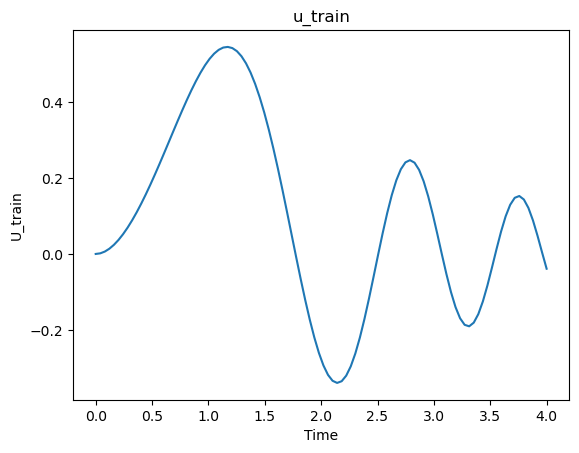

In [42]:
# 训练数据的输出
plt.plot(config.T,U_train.flatten())
plt.title("u_train")  # 设置图表标题
plt.xlabel("Time")  # 设置X轴标签
plt.ylabel("U_train")  # 设置Y轴标签

In [43]:
def skew_project(A):
    # 首先对其进行特征分解，只保留其中正的特征值
    eigvalues, eigvector = np.linalg.eigh(sym(A))
    eigvalues[eigvalues <= 0] = 0
    PA = eigvector @ np.diag(eigvalues) @ eigvector.T
    return PA

In [44]:
# 对上面的函数进行简单测试
test_m = -5*np.eye(5)
skew_project(test_m)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [45]:
def skew_symmetric(Tao,ZZ1):
    # 求解对应的skew_symmetric问题,目标函数是
    n , m = Tao.shape
    r = npl.matrix_rank(Tao)
    V,S,W = npl.svd(Tao)
    W = W.T
    S1 = S[:r]
    SS_squared = S1 ** 2
    PHI = 1 / (SS_squared[:, np.newaxis] + SS_squared)
    S1_inv = np.diag(1/S1)
    S1 = np.diag(S1)
    zz = V.T @ ZZ1 @ W
    Z1 = zz[:r,:r]
    Z3 = zz[r:,:r]
    J = np.zeros((n,n))
    J[:r,:r] = PHI * (2 * skew(Z1 @ S1))  
    J[r:,:r] = Z3 @ S1_inv
    J[:r,r:] = -(Z3 @ S1_inv).T
    JJ = V @ J @ V.T
    err = npl.norm(JJ @ Tao- ZZ1,'fro')
    # print(err)
    return JJ

In [46]:
n_symmetric = 7
M_symmetric = 500
A_symmetric = np.random.random((n_symmetric, n_symmetric))
A_symmetric = skew(A_symmetric)
X_symmetric = np.random.random((n_symmetric, M_symmetric))
r_symmetric = np.linalg.matrix_rank(X_symmetric)
Y_symmetric = A_symmetric @ X_symmetric
RES_symmetric = skew_symmetric(X_symmetric, Y_symmetric)
npl.norm(RES_symmetric @ X_symmetric- Y_symmetric,'fro')

2.205957125660848e-14

In [47]:
def phdmd(X, Y, U, delta_t, E, delta=1e-10):
    W = (X[:, 1:] - X[:, :-1]) / delta_t
    V = 1 / 2 * (X[:, 1:] + X[:, :-1])
    U = 1 / 2 * (U[:, 1:] + U[:, :-1])
    Y = 1 / 2 * (Y[:, 1:] + Y[:, :-1])

    T = np.concatenate((V, U))
    Z = np.concatenate((E @ W, -Y))
    J, R = weight_phdmd(T, Z)
    J, R, e = phdmd_FGM(T, Z, J, R,  delta)
    return J, R

In [48]:
def weight_phdmd(Tao, Z, tol=1e-12):
    # 文中给的方法是通过求解加权后的优化问题给出一个初始值估计
    r = np.linalg.matrix_rank(Tao)
    V1,Omega,WT = np.linalg.svd(Tao)
    W1 = WT.T
    # 取skin svd,其中r是Tao的秩，也就是计算其截断SVD
    Omega1 = Omega[:r]
    Omega1_inv = np.diag(1/Omega1)  # 计算文献里SVD中对角矩阵及其逆矩阵的截断
    Omega1 = np.diag(Omega1)
    Z_T = V1.T @ Z @ W1
    Z1 = Omega1 @ Z_T[:r,:r]
    JJ = skew(Z1)
    JP = skew_project(-Z1)
    J11 = V1[:,:r] @ Omega1_inv @ JJ @ Omega1_inv @ V1[:,:r].T
    R11 = V1[:,:r] @ Omega1_inv @ JP @ Omega1_inv @ V1[:,:r].T
    ERR = np.linalg.norm(Tao.T@(Z -(J11-R11)@Tao),"fro")
    return J11 , R11

In [49]:
# 测试加权phdmd，按照论文里的例子
Z_test = np.array([[-1,2],[2,-1/2]])
Tao_test = np.array([[1,0],[0,2]])
weight_phdmd(Tao_test,Z_test)

(array([[ 0. , -0.5],
        [ 0.5,  0. ]]),
 array([[ 2. , -1. ],
        [-1. ,  0.5]]))

In [50]:
def phdmd_FGM(Tao , Z ,J , R,err_end=1e-10):
    TT = Tao @ Tao.T
    eigvalues,eigvector = np.linalg.eigh(TT)
    L = max(eigvalues)
    q = min(eigvalues)/L
    max_iter = 5000
    alpha0,e0 = 0.1,0
    Q = R
    J0, R0 = J, R
    for k in range(max_iter):
        Z1 = Z + R0 @ Tao
        JK = skew_symmetric(Tao,Z1)
        Z2 = JK @ Tao - Z
        DELTA = Q @ TT - Z2 @ Tao.T
        RK = skew_project(Q-DELTA/L)
        alpha1 = 0.5*(q- alpha0**2 + np.sqrt((q-alpha0**2)**2+4*alpha0**2))
        beta = alpha0*(1-alpha0)/(alpha0**2+alpha1)
        Q = RK + beta * (RK - R0)
        err = npl.norm(RK-R0,'fro')/npl.norm(RK,"fro")+npl.norm(J0-JK,"fro")/npl.norm(JK,'fro')
        e1 = npl.norm(Z-(JK-RK)@Tao)
        if k%1000 == 0: 
            print("e",e1,"err",err)
        if err<err_end or abs(e1- e0)<err_end:   
            break
        alpha0, e0, J0, R0 = alpha1, e1, JK, RK
    err = npl.norm(Z-(J0-R0)@Tao)
    return J0,R0,err


In [51]:
# 用phDMD方法对问题进行实现，得到一个降阶模型
J_dmd, R_dmd = phdmd(X_train, Y_train, U_train, config.delta,
                        E=ph.E)
ph_dmd = PHLTI(ph.E, J_dmd, R_dmd)

e 1.1836074635123292e-14 err 6.012847422339469e-13


Text(0, 0.5, 'U_test')

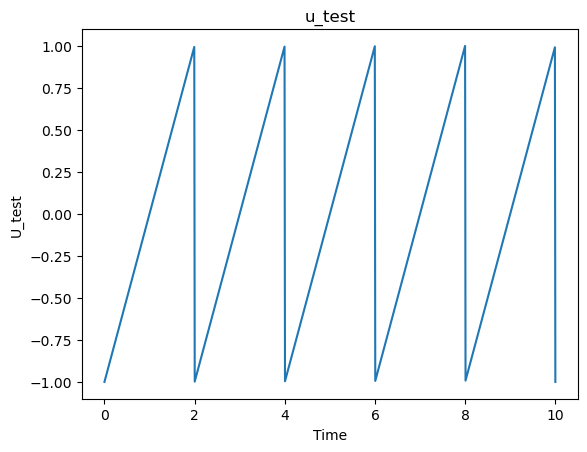

In [52]:
# 生成测试数据
U_train_dmd, X_train_dmd, Y_train_dmd = ph_dmd.sim(config.u, config.T, config.x0)
U_test, X_test, Y_test = ph.sim(config.u_test, config.T_test, config.x0)
U_dmd, X_dmd, Y_dmd = ph_dmd.sim(config.u_test, config.T_test, config.x0)

# 测试数据的输入
plt.plot(config.T_test,U_test.flatten())
plt.title("u_test")  # 设置图表标题
plt.xlabel("Time")  # 设置X轴标签
plt.ylabel("U_test")  # 设置Y轴标签

(1, 1000)

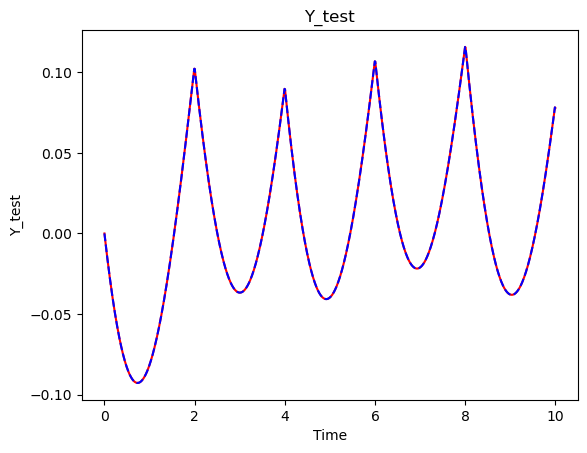

In [53]:
# 全阶模型与降阶模型的输出比较
plt.plot(config.T_test,Y_test.flatten(),'r',config.T_test,Y_dmd.flatten(),'b--')
plt.title("Y_test")  # 设置图表标题
plt.xlabel("Time")  # 设置X轴标签
plt.ylabel("Y_test")  # 设置Y轴标签
Y_test.shape

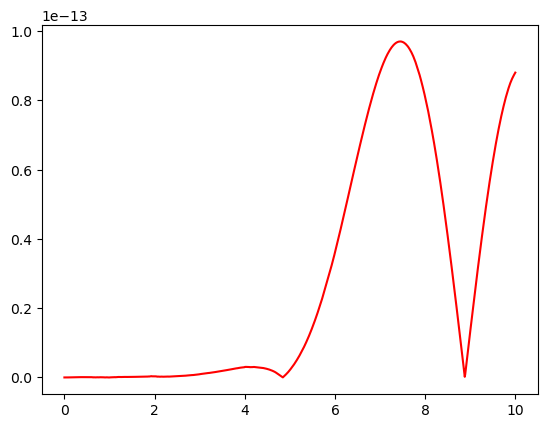

In [54]:
plt.plot(config.T_test,abs(Y_test.flatten()-Y_dmd.flatten()),'r')